# Time-in-flight analysis for tag `leios-2025w09`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
})

## Receipt of blocks

### Read results

In [2]:
receipts <- mongo(url="mongodb://thelio", db="leios2025w09", collection="receipts")$find() %>% data.table
receipts[, `:=`(`simulator`=factor(`simulator`), `ib`=factor(`ib`), `producer`=factor(`producer`), `recipient`=factor(`recipient`))]
receipts %>% summary

    elapsed               ib               ibRate          ibSize      
 Min.   :  0.0000   93-0   :    4475   Min.   : 0.50   Min.   : 32768  
 1st Qu.:  0.7195   95-0   :    4475   1st Qu.:20.00   1st Qu.: 65536  
 Median :  1.1566   57-0   :    4455   Median :30.00   Median : 98304  
 Mean   :  1.3015   86-0   :    4455   Mean   :30.36   Mean   : 95283  
 3rd Qu.:  1.7400   84-1   :    4440   3rd Qu.:50.00   3rd Qu.:131072  
 Max.   :113.7417   0-0    :    4430   Max.   :50.00   Max.   :163840  
                    (Other):14637631                                   
    producer          received        recipient             sent       
 node-99:6810122   Min.   :  0.00   node-78:  161229   Min.   :  0.00  
 node-98:1049237   1st Qu.: 38.44   node-38:  161126   1st Qu.: 37.03  
 node-97: 238997   Median : 75.83   node-67:  161084   Median : 74.19  
 node-77:  88430   Mean   : 75.82   node-90:  159671   Mean   : 74.52  
 node-26:  87253   3rd Qu.:113.03   node-31:  159556   3rd Qu.:1

### Diagnostics

### Check that the IB production rate is close to expectations

In [3]:
receipts[
    `ibSize` == 98304,
    .(
        `Actual IBs`=length(unique(`ib`)),
        `Expected IBs`=150*`ibRate`
    ),
    by=.(`simulator`, `ibRate`)
]

simulator,ibRate,Actual IBs,Expected IBs
<fct>,<dbl>,<int>,<dbl>
haskell,0.5,67,75
haskell,1.0,140,150
haskell,2.0,321,300
haskell,3.0,476,450
haskell,5.0,750,750
haskell,10.0,1475,1500
haskell,20.0,2958,3000
haskell,30.0,4437,4500
haskell,50.0,7413,7500


### Distribution of elapsed time

#### Haskell

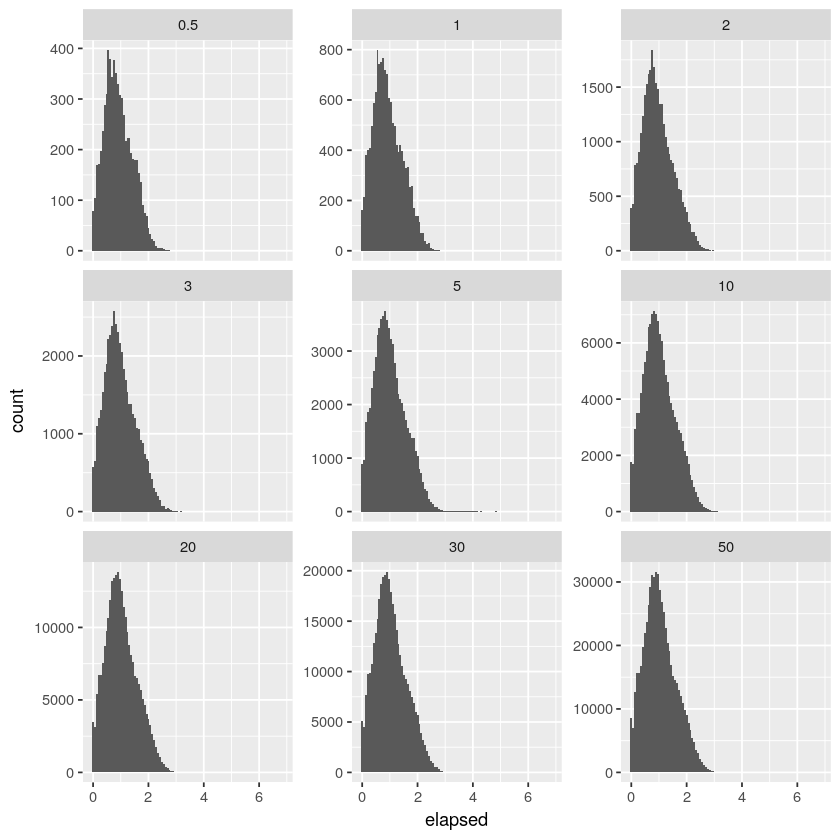

In [4]:
ggplot(receipts[`simulator` == "haskell" & `ibSize` == 98304], aes(x=`elapsed`)) +
    geom_histogram(bins=100) +
    facet_wrap(. ~ `ibRate`, scales="free_y")

#### Rust

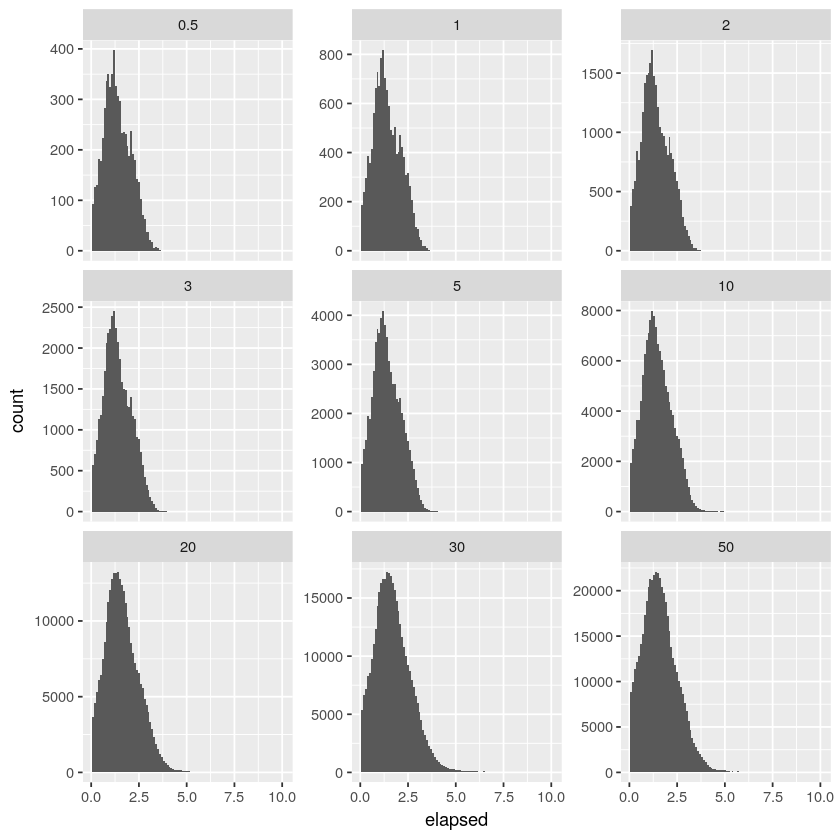

In [5]:
ggplot(receipts[`simulator` == "rust" & `ibSize` == 98304 & `elapsed` < 10], aes(x=`elapsed`)) +
    geom_histogram(bins=100) +
    facet_wrap(. ~ `ibRate`, scales="free_y")

## Link usage

### Read results

In [6]:
flight <- mongo(url="mongodb://thelio", db="leios2025w09", collection="flight")$find() %>% data.table
flight[, `:=`(`simulator`=factor(`simulator`), `kind`=factor(`kind`), `item`=factor(`item`), `sender`=factor(`sender`), `receiver`=factor(`receiver`))]
flight %>% summary

      sent              received         simulator          ibRate     
 Min.   :  0.02061   Min.   :  0.05797   rust:6801731   Min.   : 0.50  
 1st Qu.: 38.26417   1st Qu.: 38.46776                  1st Qu.:20.00  
 Median : 75.44370   Median : 75.63744                  Median :30.00  
 Mean   : 75.19405   Mean   : 75.39122                  Mean   :28.87  
 3rd Qu.:111.73810   3rd Qu.:111.93044                  3rd Qu.:50.00  
 Max.   :149.95168   Max.   :149.99998                  Max.   :50.00  
                                                                       
     ibSize       kind             sender           receiver      
 Min.   : 32768   EB:  49104   node-24: 115197   node-90:  77284  
 1st Qu.: 65536   IB:6731811   node-57:  97548   node-31:  77076  
 Median : 98304   RB:  16460   node-78:  96483   node-78:  76846  
 Mean   : 91775   Tx:   4356   node-63:  95736   node-67:  76749  
 3rd Qu.:131072                node-84:  88984   node-7 :  76525  
 Max.   :163840       

### Times to transit links

#### Rust

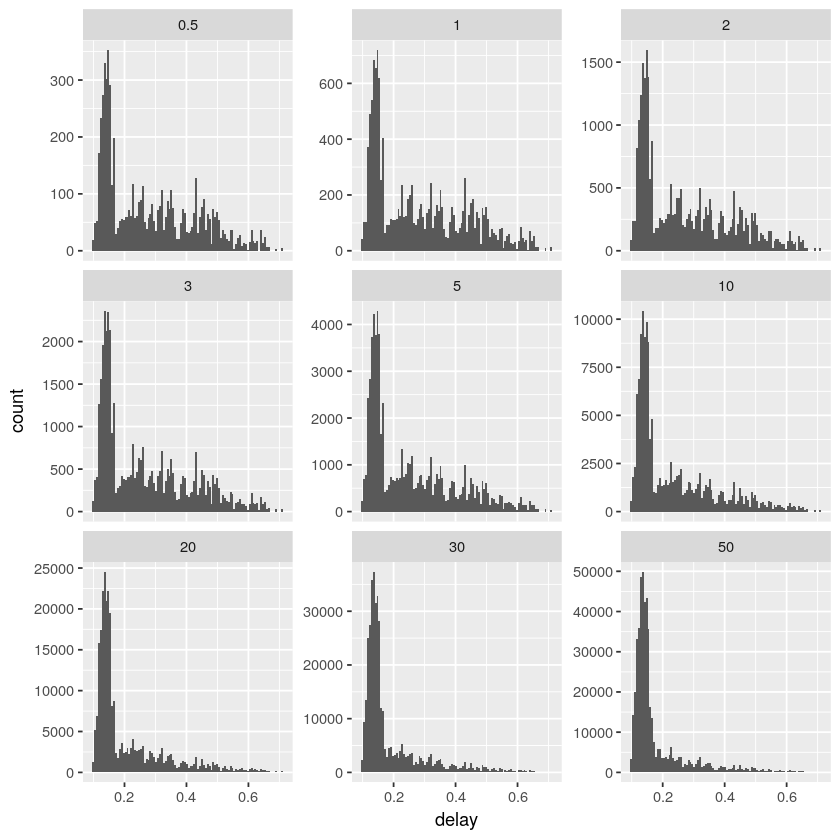

In [7]:
ggplot(flight[`simulator` == "rust" & `kind` == "IB" & `ibSize` == 98304], aes(x=`delay`)) +
    geom_histogram(bins=100) +
    facet_wrap(. ~ `ibRate`, scales="free_y")